# Ripple Report

## Introduction

In December of 2017, cryptocurrency became a popular topic of conversation after Bitcoin reached an all time high price of \$19,783 per coin from only about \$1,000 at the start of the year. Riding the wave of popularity of Bitcoin were other cryptocurrencies such as Ethereum, Ripple, and Litecoin. Not many people understood the technology behind these cryptocurrencies, but many saw it as an oppurtunity to get very rich in a short amount of time. 

I was one of those who jumped into cryptocurrency expecting to get rich. I did not go after Bitcoin however because I thought that there would be other coins with better technology and potential for growth. What caught my attention was a coin whose price was under $1 per coin and whose technology was being tested by Japanese and South Korean banks: Ripple (XRP). As soon as I could have, I put a significant amount (that I was still willing to lose) of my own money into XRP; in a short time after, I lost over half that amount.

This experience unfortunately is not uncommon, especially with amateur investors. What draws in new people into investing is the prospect of making money. However, this prospect comes along with the risk of losing a portion &mdash; big or small &mdash; of one's investment. Therefore, before investing in anything, one should always take into consideration what they would be willing to lose.

My motivation behind this project is to help out someone who is in the same position as I was in previously when it comes to investing in XRP. Therefore, there are two parts to my analysis: first, I will predict the price of XRP using ARIMA modeling, second, I will use GARCH models to model the changing variances of XRP and use that to model worst and best case scenarios for when real price observations deviate from my predictions.

## Loading Libraries

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tsap
import statsmodels.tsa as tsa

## Data Importation

For my analysis, minute to minute XRP price (in USD) data was obtained through the API at https://min-api.cryptocompare.com/, and stored into .csv's. A training set of data from July 7th, 2018, 14:40 (UTC) to July 9th, 2018, 00:00 (UTC) (2001 observations) is used to create my model for prediction. In order to verify these observations, 2001 observations from July 9th, 2018, 00:00 (UTC) to July 10th, 09:20 (UTC) is used. 

In [2]:
ripple_m = pd.read_csv("data/XRP_to_USDminute.csv", index_col=0)
ripple_m_verif = pd.read_csv("data/XRP_to_USD_verfication.csv", index_col=0)

I want to verify that the verification set starts where the training set ends.

In [3]:
ripple_m.tail()

,close,high,low,open,time,volumefrom,volumeto
1996,0.4786,0.4786,0.4783,0.4783,2018-07-08 23:56:00,7093.60,3393.28
1997,0.4782,0.4786,0.4782,0.4786,2018-07-08 23:57:00,2809.50,1344.77
1998,0.4783,0.4785,0.4782,0.4782,2018-07-08 23:58:00,6813.00,3260.91
1999,0.4782,0.4784,0.4782,0.4783,2018-07-08 23:59:00,7700.25,3684.50
2000,0.4773,0.4783,0.4773,0.4782,2018-07-09 00:00:00,51127.53,24433.76


In [4]:
ripple_m_verif.head()

,close,high,low,open,time,volumefrom,volumeto
0,0.4773,0.4783,0.4773,0.4782,2018-07-09 00:00:00,51127.53,24433.76
1,0.4774,0.4774,0.4771,0.4773,2018-07-09 00:01:00,9309.90,4444.80
2,0.4770,0.4774,0.4769,0.4774,2018-07-09 00:02:00,47729.40,22771.34
3,0.4772,0.4774,0.4769,0.4770,2018-07-09 00:03:00,632.52,304.39
4,0.4770,0.4772,0.4770,0.4772,2018-07-09 00:04:00,16261.44,7755.50


## Plotting the Data

In [5]:
ts_m = ripple_m.set_index('time')['close']

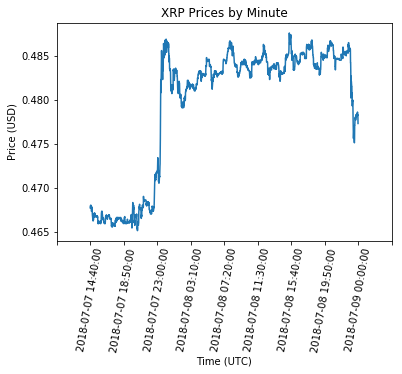

In [6]:
ts_m.plot(title='XRP Prices by Minute')
plt.ylabel('Price (USD)')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_m):
        labels.append(ts_m.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

Looking at this initial graph, one could say that there is an increasing trend. Most of the increase however came suddenly around 2018-07-07 23:00.

## ARIMA Modeling

The autoregressive integrated moving average (ARIMA) model is one of the most popular and commonly used models for dealing with time series data. Specific details about it can be read about on [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). A quick summary of it is that it is a statistical model that models future values based off of past values (autoregressive part) and past errors (moving average part). The "I" in ARIMA refers to how the model is fitted on the differenced data, rather than the raw data values themselves. The model that is fit on the already differenced data can simply be refered to as an ARMA model.

The formula for an ARMA(p,q) model is $X_t = \alpha_{1}X_{t-1} + \ldots + \alpha_{p}X_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \ldots + \theta_{q}\epsilon_{t-q}$

In order for an ARIMA model to be suitable, there are several requirements that the data has to have:
    1. Constant mean
    2. Constant variance (homoscedasticity)
    3. Constant autocorrelations between observations
    
Any set of data that has these traits is considered stationary. In reality, very little data will ever be completely stationary, especially financial data, and no statistical model will ever be perfect. However, there are a variety of transformations that can be performed on data that can make it more stationary, and there are adjustments to statistical models that can be done to make them better.

When trying to create a model for time series, there is one very commonly used process called the Box-Jenkins Methodology, whose steps are as follows:
    1. Prepare data to make it stationary
    2. Examine autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs to identify potential models
    3. Estimate parameters of potential models, and compare using various criteria
    4. Perform diagnostic checking on the residuals
    5. Forecast

I will be following Box-Jenkins Methodlogy in this analysis, so therefore I will start with transforming the price data in order to find a more stationary time series. When it comes to financial data (such as stock, cryptocurrency, or gold prices), a common approach is to use the log-returns of prices, because it is closer to being normal than just regular returns or raw price changes.

In [7]:
ts_logre = np.log(ts_m) - np.log(ts_m.shift(1))

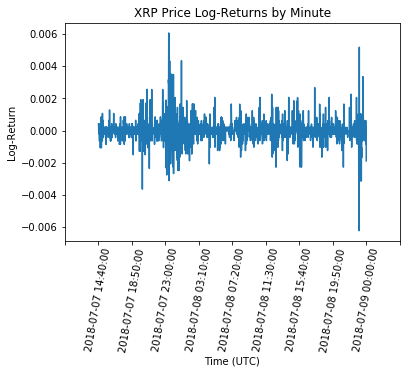

In [8]:
ts_logre.plot(title='XRP Price Log-Returns by Minute')
plt.ylabel('Log-Return')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_logre):
        labels.append(ts_logre.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

In order to better visualize the periods of different volatility, I create a time series of the variance within 200 10-minute time periods.

In [9]:
df = ts_logre.dropna()
ts_var = pd.Series()
for i in range(200):
    start = i*10
    end = (i+1)*10
    x = pd.Series(df[start:end].var(), index=[df.index[start]])
    ts_var = ts_var.append(x)

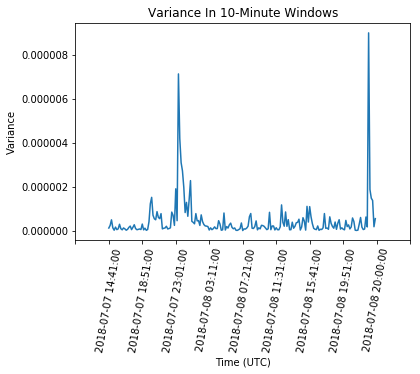

In [10]:
ts_var.plot(title='Variance In 10-Minute Windows')
plt.ylabel('Variance')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_var):
        labels.append(ts_var.index[int(l)])
    else:
        labels.append('')
labels.insert(-2, '2018-07-08 20:00:00')
plt.xticks(locs, labels, rotation=80)
plt.show()

Indeed, the variance is not always constant. It appears that whenever the variance does spike up a lot, it very quickly normalizes again. Despite the non-constant variance however, I will proceed with diagnostic checking for the data and go onto the next step: looking at the autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs.

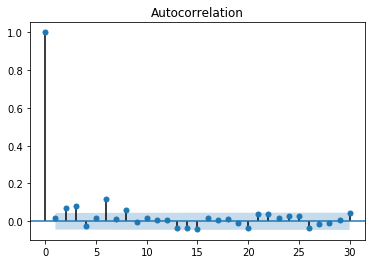

In [11]:
x = tsap.plot_acf(ts_logre.dropna(), lags=30) # need to assign to variable otherwise it plots two plots

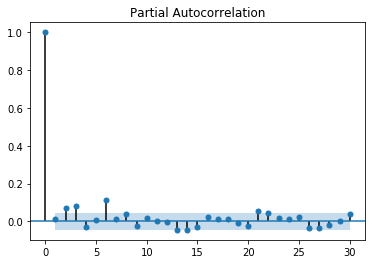

In [12]:
x = tsap.plot_pacf(ts_logre.dropna(), lags=30)

There are several lags in which the ACF and PACF functions seem significantly outside the 95 percent confidence interval, e.g. the 2nd, 3rd, and 6th lags. However, this does not seem consistent with any particular degree ARIMA model. Nonetheless, I will attempt to take AICc of multiple ARMA(p,q) models for p=0,1,2,3 and q=0,1,2,3 and see if any of the models have a lower AICc than an ARMA(0,0) (i.e. white noise) model.

In [13]:
aics = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        model = tsa.arima_model.ARMA(ts_logre.dropna(), order=(i,j))
        model_fit = model.fit(disp=0) # disp=0 to omit displaying errors
        aics[i,j] = round(model_fit.aic, 2)

In [14]:
aics

array([[-23492.1 , -23490.48, -23499.01, -23507.57],
       [-23490.54, -23490.51, -23508.5 , -23507.39],
       [-23498.66, -23508.61, -23502.02, -23513.17],
       [-23509.36, -23507.56, -23505.56, -23516.94]])

The ARMA(3,3) model appears to have the lowest AIC, however I believe that an ARMA(3,3) model would not perform significantly better than a white noise model. I create two models, the first being $X_t = \epsilon_{t}$, where $\epsilon_{t} \sim  N(0, \sigma^2)$, (I will let $\sigma^2$ be equal to a constant, the average variance, for now). The second model is $X_t = \alpha_{1}X_{t-1} + \theta_{2}X_{t-2} + \alpha_{3}X_{t-3} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + \theta_{3}\epsilon_{t-3}$, where again $\epsilon_{t} \sim  N(0, \sigma^2)$.

By the documentation of the arima_model.ARMA.fit function, the coefficients for the $\alpha's$ and $\theta's$ are found using the exact maximum likelihood via Kalman filter.

In [15]:
model2 = tsa.arima_model.ARMA(ts_logre.dropna(), order=(3,3))
model2_fit = model2.fit(disp=0)

In [16]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2000
Model:                     ARMA(3, 3)   Log Likelihood               11766.472
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sat, 21 Jul 2018   AIC                         -23516.944
Time:                        20:12:49   BIC                         -23472.137
Sample:                    07-07-2018   HQIC                        -23500.492
                         - 07-09-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.857e-06   2.03e-05      0.485      0.628      -3e-05    4.97e-05
ar.L1.close     0.0704      0.161      0.438      0.661      -0.245       0.385
ar.L2.close    -0.0928      0.122     -0.763      0.445      -0.331       0.146
ar.L3.close     0.5925      0.119      4.985      0.000       0.360       0.825
ma.L1.close    -0.0735      0.169     -0.436      0.663      -0.404       0.257
ma.L2.close     0.1656      0.129      1.279      0.201      -0.088       0.419
ma.L3.close    -0.5117      0.123     -4.158      0.000      -0.753      -0.270
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5269           -1.0567j            1.1808           -0.3236
AR.2           -0.5269           +1.0567j            1.1808            0.3236
AR.3            1.2105           -0.0000j            1.2105           -0.0000
MA.1           -0.5013           -1.1055j            1.2139           -0.3178
MA.2           -0.5013           +1.1055j            1.2139            0.3178
MA.3            1.3263           -0.0000j            1.3263           -0.0000
-----------------------------------------------------------------------------
"""

Therefore, the second model is $X_t = 0.0704X_{t-1} -0.0928X_{t-2} + 0.5925X_{t-3} + \epsilon_{t} -0.0735\epsilon_{t-1} + 0.1656\epsilon_{t-2} -0.5117\epsilon_{t-3}$

First, I plot the white noise model's predictions and 95% confidence interval on top of the test set (next 110 observations) in order to visualize its prediction accuracy.

In [17]:
variance = ts_logre.dropna().var()
pred1 = [0] * 110
upp1 = 1.96*np.sqrt(variance) + pred1
low1 = -1.96*np.sqrt(variance) + pred1

In [18]:
ts_verif = ripple_m_verif.set_index('time')['close']
ts_logre_verif = np.log(ts_verif) - np.log(ts_verif.shift(1))

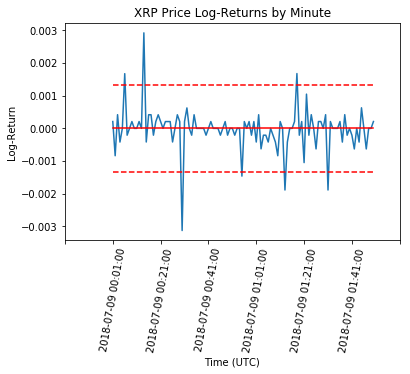

In [19]:
ts_logre_verif.dropna().head(110).plot(title='XRP Price Log-Returns by Minute')
plt.plot(pred1, 'r-')
plt.plot(upp1, 'r--')
plt.plot(low1, 'r--')
plt.ylabel('Log-Return')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_logre_verif.dropna()):
        labels.append(ts_logre_verif.dropna().index[int(l)])
    else:
        labels.append('')
labels[-1] = ''
plt.xticks(locs, labels, rotation=80)
plt.show()

It appears that a majority of the log-returns are within the 95% confidence interval of a white noise model, but during periods of high volatility, there are many more observations outside the bounds. Next, I will plot the fitted values of the ARMA(3,3) model on the training set.

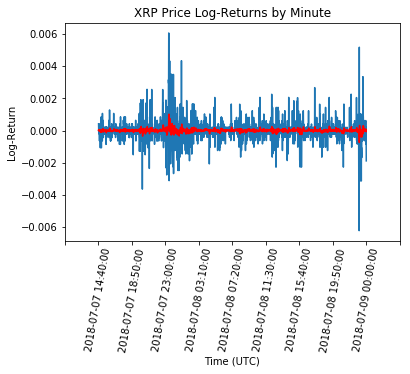

In [20]:
pred2 = model2_fit.predict().values
ts_logre.plot(title='XRP Price Log-Returns by Minute')
plt.plot(pred2, 'r-')
plt.ylabel('Log-Return')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_logre):
        labels.append(ts_logre.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

The model's fit is clearly fairly conservative when estimating that there will be large spikes in log-return.

And now, I plot the forecasts and 95% confidence interval for the next 110 observations. After each observation, the model is re-fit to forecast the next observation.

In [21]:
import datetime
ts = ts_logre_verif.dropna().head(110)
training = ts_logre.dropna()

pred = []
upp = []
low = []

for i in range(len(ts)):
    # making model and prediction for all previous observations
    model = tsa.arima_model.ARMA(training, order=(3,3))
    modelfit = model.fit(disp=0)
    forecast = modelfit.forecast(1)
    pred.append(forecast[0][0])
    upp.append(forecast[2][:,1])
    low.append(forecast[2][:,0])
    
    # updating training set with true value
    time = datetime.datetime.strptime(training.index[-1], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=1)
    time_string = datetime.datetime.strftime(time, '%Y-%m-%d %H:%M:%S')
    s = pd.Series([ts[i]], [time_string])
    training = training.append(s)

C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


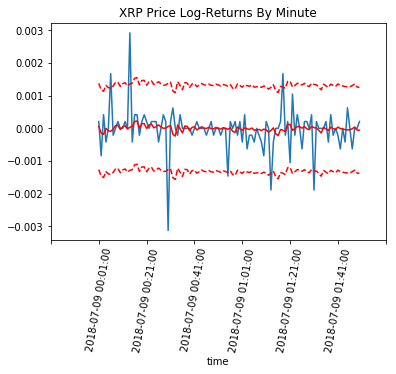

In [22]:
ts.plot(title="XRP Price Log-Returns By Minute")
plt.plot(pred, 'r-')
plt.plot(upp, 'r--')
plt.plot(low, 'r--')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts):
        labels.append(ts.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()

Although the model adjusts itself now with each observations, there is not a significant difference in this ARMA(3,3) model and the white noise model. A big part of this is because of the fact that the ARMA model assumes that there is a constant variance. How do we deal with this problem of non-constant variance (heteroskedasticity) then? The most popular approach is to model the variance itself.

# -------------------------------

Let's look again at the graph of variance in 10-minute intervals.

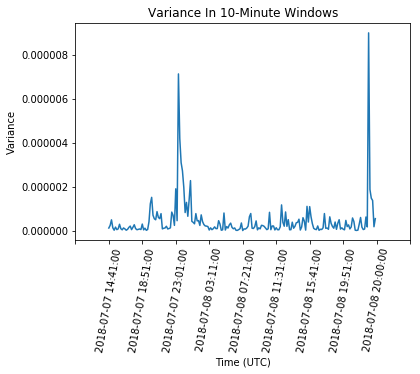

In [25]:
ts_var.plot(title='Variance In 10-Minute Windows')
plt.ylabel('Variance')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_var):
        labels.append(ts_var.index[int(l)])
    else:
        labels.append('')
labels.insert(-2, '2018-07-08 20:00:00')
plt.xticks(locs, labels, rotation=80)
plt.show()

Just like with the log-returns, we can examine the ACF and PACF of the variance.

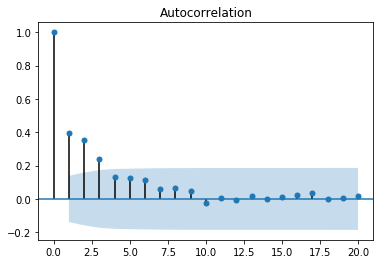

In [26]:
x = tsap.plot_acf(ts_var, lags=20)

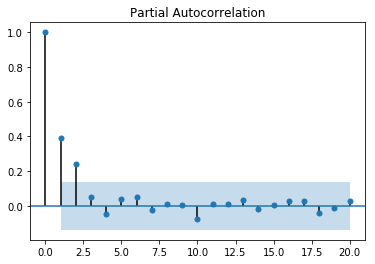

In [27]:
x = tsap.plot_pacf(ts_var, lags=20)

The PACF has a sharp cutoff after lag 2, whereas the ACF seems to be decaying over time. This strongly suggests an AR(2) model for the 10-minute variances. I will again use AIC to check various AR(p) models to see if there are any better models.

In [46]:
aics = np.zeros((6,1))
aics[1,0]
for i in range(6):
    model = tsa.arima_model.ARMA(ts_var, order=(i,0))
    model_fit = model.fit(disp=0)
    aics[i,0] = round(model_fit.aic, 2)

C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
aics

array([[-4977.9 ],
       [-5009.25],
       [-5018.86],
       [-5017.37],
       [-5015.85],
       [-5014.13]])

The AICs confirm that the model with the lowest AIC is the AR(2) model.

Just like with the log-return data, I will plot the fit of the AR(2) model on the training data, and I will plot predictions of the data onto the test set.

In [53]:
model_var = tsa.arima_model.ARMA(ts_var, order=(2,0))
model_var_fit = model_var.fit(disp=0)

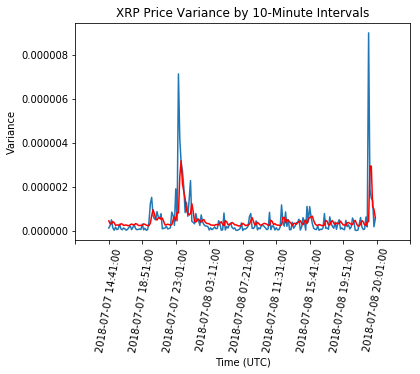

In [57]:
pred_var = model_var_fit.predict().values
ts_var.plot(title='XRP Price Variance by 10-Minute Intervals')
plt.plot(pred_var, 'r-')
plt.ylabel('Variance')
plt.xlabel('Time (UTC)')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts_var):
        labels.append(ts_var.index[int(l)])
    else:
        labels.append('')
labels[-2] = '2018-07-08 20:01:00'
plt.xticks(locs, labels, rotation=80)
plt.show()

In [48]:
df = ts_logre_verif.dropna()
ts_var_verif = pd.Series()
for i in range(200):
    start = i*10
    end = (i+1)*10
    x = pd.Series(df[start:end].var(), index=[df.index[start]])
    ts_var_verif = ts_var_verif.append(x)

In [65]:
%%capture
ts = ts_var_verif
training = ts_var

pred = []
upp = []
low = []

for i in range(len(ts)):
    # making model and prediction for all previous observations
    model = tsa.arima_model.ARMA(training, order=(2,0))
    modelfit = model.fit(disp=0)
    forecast = modelfit.forecast(1)
    l = forecast[2][:,0]
    if(l<0):
        l = 0
    pred.append(forecast[0][0])
    upp.append(forecast[2][:,1])
    low.append(l)
    
    # updating training set with true value
    time = datetime.datetime.strptime(training.index[-1], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10)
    time_string = datetime.datetime.strftime(time, '%Y-%m-%d %H:%M:%S')
    s = pd.Series([ts[i]], [time_string])
    training = training.append(s)

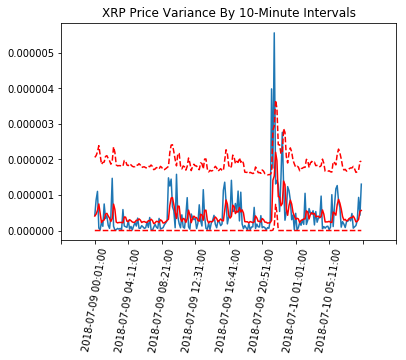

In [66]:
ts.plot(title="XRP Price Variance By 10-Minute Intervals")
plt.plot(pred, 'r-')
plt.plot(upp, 'r--')
plt.plot(low, 'r--')
locs = plt.xticks()[0]
labels = []
for l in locs:
    if 0 <= l < len(ts):
        labels.append(ts.index[int(l)])
    else:
        labels.append('')
plt.xticks(locs, labels, rotation=80)
plt.show()